<a href="https://colab.research.google.com/github/sudama-Inc/Predict-the-Business-License-Status/blob/main/predictBusinessLicenseStatus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
%matplotlib inline

import datetime
import re

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from sklearn.model_selection import KFold, cross_val_score, train_test_split

### Mount google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read Train DataSet

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/train_file.csv")
df.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS CHANGE DATE,SSA,LATITUDE,LONGITUDE,LOCATION,LICENSE STATUS
0,35342-20020816,1256593,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,2625 S CENTRAL PARK AVE 1,CHICAGO,IL,60623.0,...,2002-08-16T00:00:00,2003-08-15T00:00:00,2002-08-21T00:00:00,2006-04-11T00:00:00,NaN,25.0,41.843613,-87.714618,"{'latitude': '41.843612879431845', 'longitude'...",AAI
1,1358463-20051116,1639294,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,2825 W MONTROSE AVE,CHICAGO,IL,60618,...,2005-11-16T00:00:00,2006-11-15T00:00:00,2006-04-05T00:00:00,2006-06-12T00:00:00,2006-06-15T00:00:00,60.0,41.961132,-87.699626,"{'latitude': '41.96113244107215', 'longitude':...",AAC
2,1980233-20090722,1980233,345008,1,DJS REMODELING,"DJS REMODELING, INC.",1605 CLAVEY RD 1,HIGHLAND,IL,60035,...,2009-07-22T00:00:00,2011-07-15T00:00:00,2009-07-22T00:00:00,2009-07-22T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI


In [5]:
df.shape

(85895, 32)

In [6]:
df.columns

Index(['ID', 'LICENSE ID', 'ACCOUNT NUMBER', 'SITE NUMBER', 'LEGAL NAME',
       'DOING BUSINESS AS NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP CODE',
       'WARD', 'PRECINCT', 'WARD PRECINCT', 'POLICE DISTRICT', 'LICENSE CODE',
       'LICENSE DESCRIPTION', 'LICENSE NUMBER', 'APPLICATION TYPE',
       'APPLICATION CREATED DATE', 'APPLICATION REQUIREMENTS COMPLETE',
       'PAYMENT DATE', 'CONDITIONAL APPROVAL', 'LICENSE TERM START DATE',
       'LICENSE TERM EXPIRATION DATE', 'LICENSE APPROVED FOR ISSUANCE',
       'DATE ISSUED', 'LICENSE STATUS CHANGE DATE', 'SSA', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'LICENSE STATUS'],
      dtype='object')

In [50]:
df['LICENSE STATUS'].unique()

KeyError: ignored

In [8]:
df.isnull().sum()

ID                                       0
LICENSE ID                               0
ACCOUNT NUMBER                           0
SITE NUMBER                              0
LEGAL NAME                               0
DOING BUSINESS AS NAME                   1
ADDRESS                                  0
CITY                                     0
STATE                                    0
ZIP CODE                                31
WARD                                 49701
PRECINCT                             56701
WARD PRECINCT                        49700
POLICE DISTRICT                      54012
LICENSE CODE                             0
LICENSE DESCRIPTION                      0
LICENSE NUMBER                           1
APPLICATION TYPE                         0
APPLICATION CREATED DATE             64660
APPLICATION REQUIREMENTS COMPLETE      214
PAYMENT DATE                          1289
CONDITIONAL APPROVAL                     0
LICENSE TERM START DATE                228
LICENSE TER

**Dataset have many missing values, Let's Analyse the data**

In [9]:
df.describe()

,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,WARD,PRECINCT,POLICE DISTRICT,LICENSE CODE,LICENSE NUMBER,SSA,LATITUDE,LONGITUDE
count,8.589500e+04,85895.000000,85895.000000,36194.000000,29194.000000,31883.000000,85895.000000,8.589400e+04,9449.000000,38649.000000,38649.000000
mean,1.751303e+06,196695.421701,2.556028,28.528927,54.632973,13.529812,1111.736620,1.228151e+06,29.152080,41.880952,-87.681165
std,3.358780e+05,126819.343760,8.655706,13.921710,163.174955,7.275874,250.020872,7.431487e+05,17.419898,0.079617,0.056248
min,3.079300e+04,10.000000,1.000000,1.000000,1.000000,1.000000,1002.000000,1.290000e+02,1.000000,41.644694,-87.915285
25%,1.469024e+06,54615.000000,1.000000,17.000000,12.000000,8.000000,1010.000000,8.710900e+04,17.000000,41.834312,-87.719150
50%,1.778754e+06,248313.000000,1.000000,30.000000,26.000000,14.000000,1010.000000,1.442202e+06,28.000000,41.892679,-87.673321
75%,2.067578e+06,300243.500000,2.000000,42.000000,41.000000,19.000000,1011.000000,1.816581e+06,40.000000,41.938624,-87.639509
max,2.456551e+06,397444.000000,417.000000,50.000000,999.000000,181.000000,8340.000000,2.391410e+06,69.000000,42.022660,-87.525872


**In Data Analysis What All Things We Do**
1.   Missing Values
2.   Explore About the Numerical Variables
3.   Explore About categorical Variables
4.   Finding Relationship between features

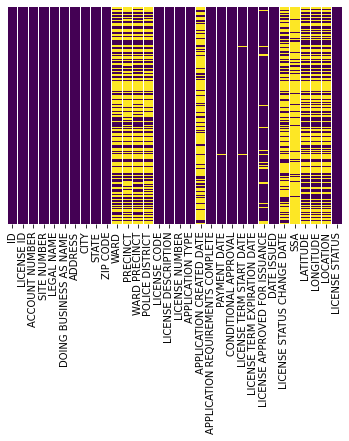

In [10]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

**Heat map**


**Compute the correlation matrix**

In [11]:
# Drop id column

df.corr()

,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,WARD,PRECINCT,POLICE DISTRICT,LICENSE CODE,LICENSE NUMBER,SSA,LATITUDE,LONGITUDE
LICENSE ID,1.000000,0.359277,0.067159,0.005275,-0.138596,-0.041838,0.010405,0.476062,0.034191,-0.023492,0.004883
ACCOUNT NUMBER,0.359277,1.000000,-0.149178,0.009602,-0.094132,-0.029867,0.063140,0.790922,0.051646,-0.012561,0.017993
SITE NUMBER,0.067159,-0.149178,1.000000,-0.015393,-0.030387,0.011103,0.109418,0.042001,0.023474,-0.005174,0.042247
WARD,0.005275,0.009602,-0.015393,1.000000,0.053996,0.487728,-0.040709,0.007125,-0.147276,0.667520,-0.233630
PRECINCT,-0.138596,-0.094132,-0.030387,0.053996,1.000000,0.184356,-0.026586,-0.121079,0.095194,0.097531,-0.105979
POLICE DISTRICT,-0.041838,-0.029867,0.011103,0.487728,0.184356,1.000000,0.048442,-0.042338,-0.014021,0.619882,-0.455247
LICENSE CODE,0.010405,0.063140,0.109418,-0.040709,-0.026586,0.048442,1.000000,0.069720,0.062682,-0.009484,-0.001010
LICENSE NUMBER,0.476062,0.790922,0.042001,0.007125,-0.121079,-0.042338,0.069720,1.000000,0.047638,-0.010265,0.029111
SSA,0.034191,0.051646,0.023474,-0.147276,0.095194,-0.014021,0.062682,0.047638,1.000000,-0.039811,0.078811
LATITUDE,-0.023492,-0.012561,-0.005174,0.667520,0.097531,0.619882,-0.009484,-0.010265,-0.039811,1.000000,-0.404510


**Make the heat map**

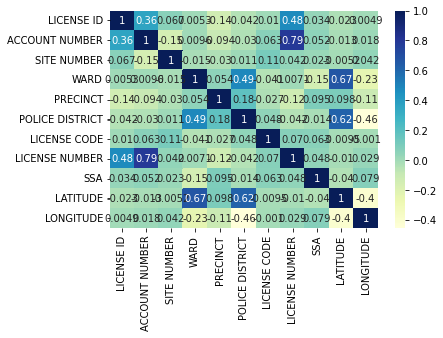

In [12]:
# plotting correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

**Compute the correlation matrix**

In [13]:
# Drop id column

df.corr()

,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,WARD,PRECINCT,POLICE DISTRICT,LICENSE CODE,LICENSE NUMBER,SSA,LATITUDE,LONGITUDE
LICENSE ID,1.000000,0.359277,0.067159,0.005275,-0.138596,-0.041838,0.010405,0.476062,0.034191,-0.023492,0.004883
ACCOUNT NUMBER,0.359277,1.000000,-0.149178,0.009602,-0.094132,-0.029867,0.063140,0.790922,0.051646,-0.012561,0.017993
SITE NUMBER,0.067159,-0.149178,1.000000,-0.015393,-0.030387,0.011103,0.109418,0.042001,0.023474,-0.005174,0.042247
WARD,0.005275,0.009602,-0.015393,1.000000,0.053996,0.487728,-0.040709,0.007125,-0.147276,0.667520,-0.233630
PRECINCT,-0.138596,-0.094132,-0.030387,0.053996,1.000000,0.184356,-0.026586,-0.121079,0.095194,0.097531,-0.105979
POLICE DISTRICT,-0.041838,-0.029867,0.011103,0.487728,0.184356,1.000000,0.048442,-0.042338,-0.014021,0.619882,-0.455247
LICENSE CODE,0.010405,0.063140,0.109418,-0.040709,-0.026586,0.048442,1.000000,0.069720,0.062682,-0.009484,-0.001010
LICENSE NUMBER,0.476062,0.790922,0.042001,0.007125,-0.121079,-0.042338,0.069720,1.000000,0.047638,-0.010265,0.029111
SSA,0.034191,0.051646,0.023474,-0.147276,0.095194,-0.014021,0.062682,0.047638,1.000000,-0.039811,0.078811
LATITUDE,-0.023492,-0.012561,-0.005174,0.667520,0.097531,0.619882,-0.009484,-0.010265,-0.039811,1.000000,-0.404510


**Make the heat map**

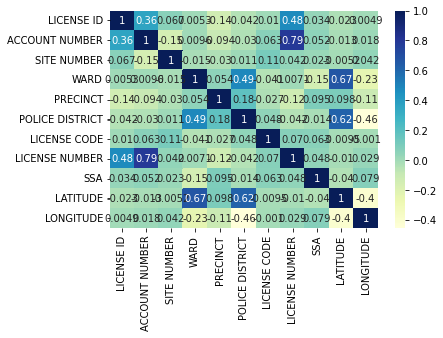

In [14]:
# plotting correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

**box Plot**

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


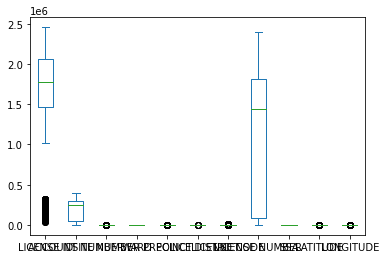

In [15]:
df.plot.box()

In [16]:
df['CONDITIONAL APPROVAL'].unique()

array(['N', 'Y'], dtype=object)

In [17]:
##HAndling categorical feature CONDITIONAL APPROVAL
df['CONDITIONAL APPROVAL']=df['CONDITIONAL APPROVAL'].map({'N':0,'Y':1})
df.head()

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS CHANGE DATE,SSA,LATITUDE,LONGITUDE,LOCATION,LICENSE STATUS
0,35342-20020816,1256593,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,2625 S CENTRAL PARK AVE 1,CHICAGO,IL,60623.0,...,2002-08-16T00:00:00,2003-08-15T00:00:00,2002-08-21T00:00:00,2006-04-11T00:00:00,NaN,25.0,41.843613,-87.714618,"{'latitude': '41.843612879431845', 'longitude'...",AAI
1,1358463-20051116,1639294,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,2825 W MONTROSE AVE,CHICAGO,IL,60618,...,2005-11-16T00:00:00,2006-11-15T00:00:00,2006-04-05T00:00:00,2006-06-12T00:00:00,2006-06-15T00:00:00,60.0,41.961132,-87.699626,"{'latitude': '41.96113244107215', 'longitude':...",AAC
2,1980233-20090722,1980233,345008,1,DJS REMODELING,"DJS REMODELING, INC.",1605 CLAVEY RD 1,HIGHLAND,IL,60035,...,2009-07-22T00:00:00,2011-07-15T00:00:00,2009-07-22T00:00:00,2009-07-22T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
3,1476582-20040211,1476582,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,8 NORTH TRAIL,LEMONT,IL,60439,...,2004-02-11T00:00:00,2005-02-15T00:00:00,2004-02-10T00:00:00,2004-02-11T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
4,1141408-20080516,1896750,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,4081 JOSEPH DR,WAUKEGAN,IL,60087,...,2008-05-16T00:00:00,2010-05-15T00:00:00,2008-06-04T00:00:00,2008-06-05T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI


In [18]:
# find Object type of features
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['ID', 'LEGAL NAME', 'DOING BUSINESS AS NAME', 'ADDRESS', 'CITY',
       'STATE', 'ZIP CODE', 'WARD PRECINCT', 'LICENSE DESCRIPTION',
       'APPLICATION TYPE', 'APPLICATION CREATED DATE',
       'APPLICATION REQUIREMENTS COMPLETE', 'PAYMENT DATE',
       'LICENSE TERM START DATE', 'LICENSE TERM EXPIRATION DATE',
       'LICENSE APPROVED FOR ISSUANCE', 'DATE ISSUED',
       'LICENSE STATUS CHANGE DATE', 'LOCATION', 'LICENSE STATUS'],
      dtype='object')

In [19]:
## APPLICATION TYPE replace missing values
print(df['APPLICATION TYPE'].unique())
print()
print(df['APPLICATION TYPE'].value_counts())

['RENEW' 'ISSUE' 'C_LOC' 'C_EXPA' 'C_CAPA']

RENEW     61085
ISSUE     23398
C_LOC      1400
C_CAPA        7
C_EXPA        5
Name: APPLICATION TYPE, dtype: int64


In [20]:
## LICENSE DESCRIPTION replace missing values
df['LICENSE DESCRIPTION'].unique().shape

(106,)

In [21]:
# LICENSE STATUS
df['LICENSE STATUS'].unique()

array(['AAI', 'AAC', 'REV', 'REA', 'INQ'], dtype=object)

**Replace the missing values with mode on missing values - WARD, PRECINCT, POLICE DISTRICT, LICENSE CODE**

In [22]:
## Replace the missing values with mode for INT64
df['WARD']=df['WARD'].fillna(df['WARD'].mode()[0])
df['PRECINCT']=df['PRECINCT'].fillna(df['PRECINCT'].mode()[0])
df['POLICE DISTRICT']=df['POLICE DISTRICT'].fillna(df['POLICE DISTRICT'].mode()[0])
df['LICENSE CODE']=df['LICENSE CODE'].fillna(df['LICENSE CODE'].mode()[0])

In [23]:
## Replace the missing values with mode for float64

df['LICENSE NUMBER']=df['LICENSE NUMBER'].fillna(df['LICENSE NUMBER'].mean())
df['SSA']=df['SSA'].fillna(df['SSA'].median())
df['LATITUDE']=df['LATITUDE'].fillna(df['LATITUDE'].median())
df['LONGITUDE']=df['LONGITUDE'].fillna(df['LONGITUDE'].median())

**Type cast ZIP CODE from object to int64**

In [24]:
# df['ZIP CODE']=df['ZIP CODE'].astype(float)

df['ZIP CODE'].unique().shape

(2457,)

In [25]:
for i in df['ZIP CODE']:
  if isinstance(i, np.float64):
    df['ZIP CODE'] = df['ZIP CODE'].replace(np.nan, 0)
  
# df['ZIP CODE'] = df['ZIP CODE'].astype(float)
  
#df['ZIP CODE'].fillna(df['ZIP CODE'].median()

In [34]:
# str_char = ['L5K', 'J3Y8Y', 'H2T2V', 'H3P3C', 'M4N', 'T5H2E', 'H3P']
for i in df['ZIP CODE']:
  if 'H3P' in str(i):
    df['ZIP CODE'] = df['ZIP CODE'].replace('H3P', 0)

In [35]:
df['ZIP CODE'] = df['ZIP CODE'].astype(np.float64)

In [36]:
df['ZIP CODE']=df['ZIP CODE'].fillna(df['ZIP CODE'].median())

In [37]:
df['ZIP CODE'].isnull().sum()

0

**Convert datetime object into datetime**

In [38]:
df['APPLICATION CREATED DATE']=pd.to_datetime(df['APPLICATION CREATED DATE'])
df['APPLICATION REQUIREMENTS COMPLETE']=pd.to_datetime(df['APPLICATION REQUIREMENTS COMPLETE'])
df['PAYMENT DATE']=pd.to_datetime(df['PAYMENT DATE'])
df['CONDITIONAL APPROVAL']=pd.to_datetime(df['CONDITIONAL APPROVAL'])
df['LICENSE TERM START DATE']=pd.to_datetime(df['LICENSE TERM START DATE'])
df['LICENSE TERM EXPIRATION DATE']=pd.to_datetime(df['LICENSE TERM EXPIRATION DATE'])
df['LICENSE APPROVED FOR ISSUANCE']=pd.to_datetime(df['LICENSE APPROVED FOR ISSUANCE'])
df['DATE ISSUED']=pd.to_datetime(df['DATE ISSUED'])
df['LICENSE STATUS CHANGE DATE']=pd.to_datetime(df['LICENSE STATUS CHANGE DATE'])

**Replace the NaT values with mode**

In [39]:
df['APPLICATION CREATED DATE']=df['APPLICATION CREATED DATE'].fillna(df['APPLICATION CREATED DATE'].median())
df['APPLICATION REQUIREMENTS COMPLETE']=df['APPLICATION REQUIREMENTS COMPLETE'].fillna(df['APPLICATION REQUIREMENTS COMPLETE'].median())
df['PAYMENT DATE']=df['PAYMENT DATE'].fillna(df['PAYMENT DATE'].median())
df['LICENSE TERM START DATE']=df['LICENSE TERM START DATE'].fillna(df['LICENSE TERM START DATE'].median())
df['LICENSE TERM EXPIRATION DATE']=df['LICENSE TERM EXPIRATION DATE'].fillna(df['LICENSE TERM EXPIRATION DATE'].median())
df['LICENSE APPROVED FOR ISSUANCE']=df['LICENSE APPROVED FOR ISSUANCE'].fillna(df['LICENSE APPROVED FOR ISSUANCE'].median())
df['LICENSE STATUS CHANGE DATE']=df['LICENSE STATUS CHANGE DATE'].fillna(df['LICENSE STATUS CHANGE DATE'].median())

**Cam drop name address state and other columns**

In [42]:
# Dropped

# df.drop(['ID', 'LEGAL NAME', 'DOING BUSINESS AS NAME', 'ADDRESS', 'WARD PRECINCT', 'LOCATION'], axis=1, inplace=True)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85895 entries, 0 to 85894
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   LICENSE ID                         85895 non-null  int64         
 1   ACCOUNT NUMBER                     85895 non-null  int64         
 2   SITE NUMBER                        85895 non-null  int64         
 3   CITY                               85895 non-null  object        
 4   STATE                              85895 non-null  object        
 5   ZIP CODE                           85895 non-null  float64       
 6   WARD                               85895 non-null  float64       
 7   PRECINCT                           85895 non-null  float64       
 8   POLICE DISTRICT                    85895 non-null  float64       
 9   LICENSE CODE                       85895 non-null  int64         
 10  LICENSE DESCRIPTION               

In [44]:
df.isnull().sum()

LICENSE ID                           0
ACCOUNT NUMBER                       0
SITE NUMBER                          0
CITY                                 0
STATE                                0
ZIP CODE                             0
WARD                                 0
PRECINCT                             0
POLICE DISTRICT                      0
LICENSE CODE                         0
LICENSE DESCRIPTION                  0
LICENSE NUMBER                       0
APPLICATION TYPE                     0
APPLICATION CREATED DATE             0
APPLICATION REQUIREMENTS COMPLETE    0
PAYMENT DATE                         0
CONDITIONAL APPROVAL                 0
LICENSE TERM START DATE              0
LICENSE TERM EXPIRATION DATE         0
LICENSE APPROVED FOR ISSUANCE        0
DATE ISSUED                          0
LICENSE STATUS CHANGE DATE           0
SSA                                  0
LATITUDE                             0
LONGITUDE                            0
LICENSE STATUS           

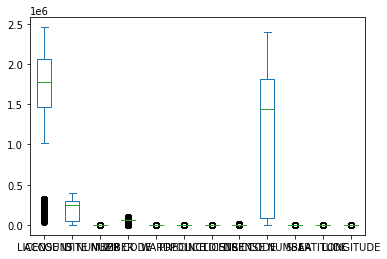

In [45]:
df.plot.box()

**To handeling Categorical features we can use various methods, here i am using get_dummies**

1.   We also can try other methods like OneHotEncoding, LevelEncoding ans SimpleImputer



In [46]:
df = pd.get_dummies(df,columns=["CITY", "STATE", "APPLICATION TYPE", "LICENSE DESCRIPTION", "LICENSE STATUS"] ,drop_first = True)

In [48]:
df.columns

Index(['LICENSE ID', 'ACCOUNT NUMBER', 'SITE NUMBER', 'ZIP CODE', 'WARD',
       'PRECINCT', 'POLICE DISTRICT', 'LICENSE CODE', 'LICENSE NUMBER',
       'APPLICATION CREATED DATE',
       ...
       'LICENSE DESCRIPTION_Vacation Rental',
       'LICENSE DESCRIPTION_Valet Parking Operator',
       'LICENSE DESCRIPTION_Veterinary Hospital',
       'LICENSE DESCRIPTION_Weapons Dealer',
       'LICENSE DESCRIPTION_Wholesale Food Establishment',
       'LICENSE DESCRIPTION_Wrigley Field', 'LICENSE STATUS_AAI',
       'LICENSE STATUS_INQ', 'LICENSE STATUS_REA', 'LICENSE STATUS_REV'],
      dtype='object', length=1409)

In [84]:
# Dropped All datetime colume because while trining the models they are not training

X=df.drop(['APPLICATION CREATED DATE', 'APPLICATION REQUIREMENTS COMPLETE','PAYMENT DATE', 'CONDITIONAL APPROVAL', 'LICENSE TERM START DATE','LICENSE TERM EXPIRATION DATE', 'LICENSE APPROVED FOR ISSUANCE', 'DATE ISSUED', 'LICENSE STATUS CHANGE DATE'], axis = 1)

In [51]:
X=df.drop(['LICENSE STATUS_AAI','LICENSE STATUS_INQ', 'LICENSE STATUS_REA', 'LICENSE STATUS_REV'], axis = 1)

In [76]:
X.head()

,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,ZIP CODE,WARD,PRECINCT,POLICE DISTRICT,LICENSE CODE,LICENSE NUMBER,SSA,...,LICENSE DESCRIPTION_Vacation Rental,LICENSE DESCRIPTION_Valet Parking Operator,LICENSE DESCRIPTION_Veterinary Hospital,LICENSE DESCRIPTION_Weapons Dealer,LICENSE DESCRIPTION_Wholesale Food Establishment,LICENSE DESCRIPTION_Wrigley Field,LICENSE STATUS_AAI,LICENSE STATUS_INQ,LICENSE STATUS_REA,LICENSE STATUS_REV
0,1256593,32811,1,60623.0,22.0,28.0,10.0,1010,35342.0,25.0,...,0,0,0,0,0,0,1,0,0,0
1,1639294,262311,29,60618.0,33.0,23.0,17.0,1315,1358463.0,60.0,...,0,0,0,0,0,0,0,0,0,0
2,1980233,345008,1,60035.0,42.0,9.0,18.0,1011,1980233.0,28.0,...,0,0,0,0,0,0,1,0,0,0
3,1476582,273121,1,60439.0,42.0,9.0,18.0,1010,1476582.0,28.0,...,0,0,0,0,0,0,1,0,0,0
4,1896750,213785,1,60087.0,42.0,9.0,18.0,1010,1141408.0,28.0,...,0,0,0,0,0,0,1,0,0,0


In [77]:
X.shape

(85895, 1400)

In [57]:
y=df[['LICENSE STATUS_AAI','LICENSE STATUS_INQ', 'LICENSE STATUS_REA', 'LICENSE STATUS_REV']]

In [58]:
y

,LICENSE STATUS_AAI,LICENSE STATUS_INQ,LICENSE STATUS_REA,LICENSE STATUS_REV
0,1,0,0,0
1,0,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
85890,0,0,0,0
85891,1,0,0,0
85892,1,0,0,0
85893,0,0,0,0


In [59]:
y.shape

(85895, 4)

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [79]:
X_train

,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,ZIP CODE,WARD,PRECINCT,POLICE DISTRICT,LICENSE CODE,LICENSE NUMBER,SSA,...,LICENSE DESCRIPTION_Vacation Rental,LICENSE DESCRIPTION_Valet Parking Operator,LICENSE DESCRIPTION_Veterinary Hospital,LICENSE DESCRIPTION_Weapons Dealer,LICENSE DESCRIPTION_Wholesale Food Establishment,LICENSE DESCRIPTION_Wrigley Field,LICENSE STATUS_AAI,LICENSE STATUS_INQ,LICENSE STATUS_REA,LICENSE STATUS_REV
33768,1479463,274153,25,60644.0,29.0,16.0,15.0,1010,1479463.0,28.0,...,0,0,0,0,0,0,0,0,0,0
69664,2306418,255088,1,60473.0,42.0,9.0,18.0,1010,1301788.0,28.0,...,0,0,0,0,0,0,1,0,0,0
37278,1327123,245935,1,46312.0,42.0,9.0,18.0,1010,1243904.0,28.0,...,0,0,0,0,0,0,1,0,0,0
39209,1915675,330718,2,60609.0,20.0,4.0,9.0,1010,1915675.0,28.0,...,0,0,0,0,0,0,0,0,0,0
62629,2143828,32008,3,60532.0,42.0,9.0,18.0,1010,2027570.0,28.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,1542987,282868,1,60634.0,36.0,17.0,16.0,1525,1542987.0,28.0,...,0,0,0,0,0,0,0,0,0,0
54886,1918238,85937,1,60606.0,42.0,9.0,1.0,1010,26083.0,28.0,...,0,0,0,0,0,0,0,0,0,0
76820,2093534,361743,1,60647.0,31.0,9.0,18.0,1010,2093534.0,28.0,...,0,0,0,0,0,0,1,0,0,0
860,1554986,30756,1,46383.0,42.0,9.0,18.0,1010,27349.0,28.0,...,0,0,0,0,0,0,1,0,0,0


In [80]:
print(X_train.shape)
print()
print(y_train.shape)


(57549, 1400)

(57549, 4)


In [63]:
y_train

,LICENSE STATUS_AAI,LICENSE STATUS_INQ,LICENSE STATUS_REA,LICENSE STATUS_REV
33768,0,0,0,0
69664,1,0,0,0
37278,1,0,0,0
39209,0,0,0,0
62629,1,0,0,0
...,...,...,...,...
6265,0,0,0,0
54886,0,0,0,0
76820,1,0,0,0
860,1,0,0,0


**Let's Normalize our data by using Min-Max Scaler**

*   It will scale down our feature values in between [0,1]




In [71]:
# from sklearn.preprocessing import MinMaxScaler
# sc=MinMaxScaler()
# X_train=sc.fit_transform(X_train)
# X_test=sc.transform(X_test)

In [72]:
# scaling.fit_transform(df[['LICENSE ID', 'ACCOUNT NUMBER', 'SITE NUMBER', 'ZIP CODE', 'WARD', 'PRECINCT', 'POLICE DISTRICT', 'LICENSE CODE', 'LICENSE NUMBER', 'LATITUDE', 'LONGITUDE']])

**Let's apply models**

**1. Linear Regression**

In [82]:
from sklearn.linear_model import LinearRegression
ln=LinearRegression()
ln.fit(X_train, y_train)

LinearRegression()

In [83]:
ln.intercept_

array([ 0.00017388,  0.01432243,  0.00586657, -0.00012823])

In [85]:
ln.coef_

array([[-7.48114209e-17, -1.32761985e-16, -1.37797607e-11, ...,
        -5.76270612e-10,  3.28391766e-10, -4.15872010e-10],
       [ 2.53229404e-20, -2.55542975e-19, -5.95036945e-15, ...,
         1.00000000e+00,  2.53518994e-14, -4.19233658e-13],
       [ 3.82760825e-21, -4.24565959e-21,  5.42134602e-15, ...,
        -1.37548631e-12,  1.00000000e+00,  6.67891306e-14],
       [ 1.41818195e-18, -4.26359163e-18,  4.00994104e-13, ...,
         2.34526736e-11, -3.14526083e-11,  1.00000000e+00]])

In [86]:
ln.predict(X_test)

array([[-2.98017115e-10, -3.98922215e-13,  1.93895247e-13,
         1.11053839e-11],
       [-4.77777331e-11, -1.11697110e-13,  8.66797953e-14,
        -3.44765720e-14],
       [ 1.00000000e+00, -5.53007293e-13, -4.51843424e-13,
         1.01475615e-10],
       ...,
       [ 1.00000000e+00, -4.18807176e-12, -3.53735270e-13,
         7.28326731e-11],
       [ 1.00000000e+00,  1.45058271e-12, -4.58651346e-13,
        -3.74158579e-12],
       [-2.39370900e-10,  9.44595097e-13, -2.73056751e-13,
        -5.85502838e-13]])

In [87]:
y_pred=ln.predict(X_test)
y_pred

array([[-2.98017115e-10, -3.98922215e-13,  1.93895247e-13,
         1.11053839e-11],
       [-4.77777331e-11, -1.11697110e-13,  8.66797953e-14,
        -3.44765720e-14],
       [ 1.00000000e+00, -5.53007293e-13, -4.51843424e-13,
         1.01475615e-10],
       ...,
       [ 1.00000000e+00, -4.18807176e-12, -3.53735270e-13,
         7.28326731e-11],
       [ 1.00000000e+00,  1.45058271e-12, -4.58651346e-13,
        -3.74158579e-12],
       [-2.39370900e-10,  9.44595097e-13, -2.73056751e-13,
        -5.85502838e-13]])

**Model Evaluation**

In [89]:
from sklearn import metrics

In [90]:
metrics.r2_score(y_test, y_pred)

0.7499806355539662

In [92]:
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

In [98]:
# print(accuracy_score(y_test,y_pred))

# ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [97]:
# classification_report(y_test,y_pred)

# ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

**2. Logistic Regression**

In [96]:
# from sklearn.linear_model import LogisticRegression
# lgr=LogisticRegression()
# lgr.fit(X_train, y_train)

# ValueError: y should be a 1d array, got an array of shape (57549, 4) instead.

**3. KMeans Clustering**

In [99]:
from sklearn.cluster import KMeans

In [100]:
kmeans=KMeans()

In [101]:
kmeans.fit(X)

KMeans()

In [103]:
kmeans.predict(X)

array([6, 5, 2, ..., 3, 2, 0], dtype=int32)

In [102]:
km4=KMeans(n_clusters=4).fit(X)

In [104]:
km4.predict(X)

array([3, 2, 1, ..., 0, 1, 2], dtype=int32)

In [105]:
km_inertia=[]
k_val= list(range(2,10))
for k in k_val:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(X)
    km_inertia.append(kmeans.inertia_)

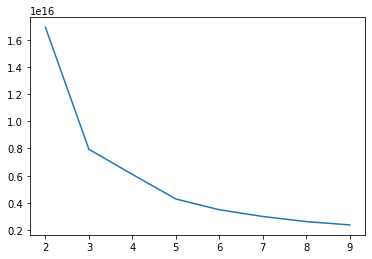

In [106]:
plt.plot(k_val,km_inertia )

**4. PCA**

In [107]:
from sklearn.decomposition import PCA
pca=PCA()
pca_data=pca.fit_transform(X)

In [108]:
pca_data

array([[ 1.28801957e+06,  1.88097927e+05, -3.75031291e+03, ...,
        -4.06185595e-18,  1.90910677e-18, -2.47257681e-18],
       [-1.06704797e+05,  1.42642130e+05,  4.58200758e+04, ...,
         3.82310531e-18,  3.30437827e-18, -4.04330409e-19],
       [-7.97880651e+05, -3.61086409e+04,  4.59927044e+04, ...,
        -2.00466682e-18, -1.24643729e-18,  2.07983252e-18],
       ...,
       [ 1.08842113e+06, -4.66079054e+05, -2.56303998e+04, ...,
        -3.88011931e-21, -7.03341597e-22, -2.06193940e-20],
       [-8.51140949e+05, -1.60603861e+05, -3.01672735e+05, ...,
         3.20825325e-20,  2.54090921e-20, -3.04607401e-22],
       [ 2.20849349e+05,  2.43734856e+05,  2.76609475e+04, ...,
         1.58540758e-20, -2.49917333e-20,  8.86639096e-21]])

In [109]:
pca.components_

array([[-2.42380182e-01, -1.30781376e-01, -4.82185646e-07, ...,
        -1.98481896e-13,  2.77574210e-11, -2.03198640e-10],
       [-9.70117680e-01,  4.40012783e-02, -1.59429810e-06, ...,
         1.21897068e-10, -1.81291103e-10, -1.03666702e-08],
       [ 1.10952554e-02,  9.90431708e-01, -3.34012706e-05, ...,
         1.33002303e-10,  6.50438811e-11,  7.50172733e-09],
       ...,
       [ 0.00000000e+00, -2.14060208e-23, -2.36133694e-18, ...,
         3.81639165e-17,  8.45677695e-17, -1.04083409e-17],
       [ 0.00000000e+00,  6.05608502e-22, -2.53407736e-18, ...,
        -5.68121938e-17,  8.80372164e-17, -2.42861287e-17],
       [-0.00000000e+00, -1.32240440e-21,  8.95427452e-18, ...,
         1.73472348e-17, -2.94902991e-17,  2.77555756e-17]])

In [110]:
pca.explained_variance_

array([5.92364354e+11, 8.28930401e+10, 5.90342372e+09, ...,
       1.10794349e-36, 1.00030420e-36, 7.99561343e-37])

In [111]:
pca.explained_variance_ratio_

array([8.69590255e-01, 1.21686897e-01, 8.66621987e-03, ...,
       1.62645989e-48, 1.46844552e-48, 1.17375522e-48])

**5. KNN**

In [112]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=3)

In [113]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [114]:
y_pred=knn.predict(X_test)

In [115]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [117]:
print(accuracy_score(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.767974317364002
              precision    recall  f1-score   support

           0       0.81      0.84      0.82     18203
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.23      0.16      0.19        88

   micro avg       0.81      0.84      0.82     18292
   macro avg       0.26      0.25      0.25     18292
weighted avg       0.81      0.84      0.82     18292
 samples avg       0.54      0.54      0.54     18292



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [119]:
#f1-score=2*recall*precision/(recall+precision)
acc_sc=[]
k_val=[]
for k in range(3, 20, 2):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn=knn.predict(X_test)
    acc_sc.append(accuracy_score(y_test, y_pred_knn))
    k_val.append(k)

In [120]:
acc_sc

[0.767974317364002,
 0.7722782755944402,
 0.7752063783249842,
 0.7755238834403443,
 0.7764058420941227,
 0.7757708318634022,
 0.7748535948634728,
 0.7753474917095886,
 0.7730896775559162]

In [121]:
k

19

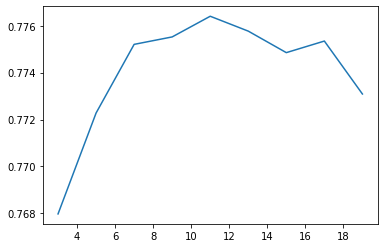

In [122]:
plt.plot(k_val,acc_sc)
plt.show()

**6. Ensemble_Learning**

**6.1 RandomForestClassifier**

In [123]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)

In [124]:
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=600)

In [125]:
predictions = rfc.predict(X_test)

In [126]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18203
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       1.00      0.95      0.98        88

   micro avg       1.00      1.00      1.00     18292
   macro avg       0.50      0.49      0.49     18292
weighted avg       1.00      1.00      1.00     18292
 samples avg       0.65      0.65      0.65     18292



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

**6.2 AdaBoost**

In [134]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=60000)

In [139]:
# abc.fit(X_train,y_train)

**6.3 Gradient Boosting**

In [133]:
from sklearn.ensemble import GradientBoostingClassifier

**6.4 XGBoost**

In [136]:
from xgboost import XGBClassifier

In [138]:
# xgbc=XGBClassifier()
# xgbc.fit(X_train,y_train)
# xgbc_pred=xgbc.predict(X_test)
# print('accuracy_score: ', accuracy_score(y_test,xgbc_pred))
# print("Confusion Matrix:\n" ,confusion_matrix(y_test,xgbc_pred))
# print("Recall: ",recall_score(y_test,xgbc_pred))
# print("precision:  ", precision_score(y_test,xgbc_pred))
# print("f1_score: ", f1_score(y_test,xgbc_pred))


# ValueError: y should be a 1d array, got an array of shape (57549, 4) instead.